In [62]:
import torch
import numpy as np
from sklearn import linear_model, tree
from sklearn.neural_network import MLPClassifier
from torch import nn, optim
from torch.autograd.variable import Variable
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import joblib

In [63]:
loss = None
d_loss_arr = []
g_loss_arr = []


In [64]:
class DiscriminatorNet(torch.nn.Module):
    """
    the discriminator that contains 2 hidden layer
    this networks works to decrease loss and learn what the adversarial examples are
    """
    def __init__(self, sigmoid):
        super(DiscriminatorNet, self).__init__()
        n_features = 128
        n_out = 1
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512)
        )
        if sigmoid:
            self.out = nn.Sequential(
                torch.nn.Linear(512, n_out),  # changed input size to 512
                nn.Sigmoid()
            )
        else:
            self.out = nn.Sequential(
                torch.nn.Linear(512, n_out),  # no need to change, input size is already 512
                torch.nn.Tanh()
            )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x


In [65]:
class GeneratorNet(torch.nn.Module):
    """
    a neural network with two hidden layers
    this network is used to create adversarial examples
    """
    def __init__(self, sigmoid):
        super(GeneratorNet, self).__init__()
        n_features = 148
        n_out = 128
        if sigmoid:
            self.hidden0 = nn.Sequential(
                nn.Linear(n_features, 256),
            )
            self.hidden1 = nn.Sequential(
                nn.Linear(256, 512)
            )
            # self.hidden2= nn.Sequential(
            #     nn.Linear(512, 512)
            # )
            self.out = nn.Sequential(
                nn.Linear(512, n_out),
                torch.nn.Sigmoid()
            )
        else:
            self.hidden0 = nn.Sequential(
                nn.Linear(n_features, 256)
            )
            self.hidden1 = nn.Sequential(
                nn.Linear(256, 512)
            )
            # self.hidden2= nn.Sequential(
            #     nn.Linear(512, 512)
            # )
            self.out = nn.Sequential(
                nn.Linear(512, n_out),
                torch.nn.Tanh()
            )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        # x = self.hidden2(x)
        x = self.out(x)
        return x

In [66]:
def real_data_target(size):
    """
    creates a tensor of the expected labels of real data
    :param size:
    :return:
    """
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data


def fake_data_target(size):
    """
    creates a tensor of the expcted labels of fake data
    :param size:
    :return:
    """
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data


def train_discriminator(optimizer, real_data, real_data_labels, fake_data, fake_data_labels):
    """
    trains the discriminator or real data and fake data
    and computes a loss for each of them
    """
    global discriminator, generator
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = nn.MSELoss()(prediction_real,real_data_labels)
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = nn.MSELoss()(prediction_fake, fake_data_labels)
    error_fake.backward()
    optimizer.step()
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data, fake_data_labels):
    """
    trains the gnerator giving the discriminator fake data and computes tje loss
    """
    global discriminator, loss, generator
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = nn.MSELoss()(prediction, fake_data_labels)
    error.backward()
    optimizer.step()
    return error


In [67]:
def load_data():
    """
    loads the data set
    :return:
    """
    data_set = "C:/Mal-GAN/MalGAN-master/MalGAN-master/data/data1.npz"
    data = np.load(data_set)
    xmal, ymal, xben, yben = data['xmal'], data['ymal'], data['xben'], data['yben']
    return (xmal, ymal), (xben, yben)


In [68]:
def train(num_epochs, blackbox, generator, d_optimizer, g_optimizer, train_tpr, test_tpr, sigmoid, isFirst=True):
    """
    trains MalGAN by creating a blackbox and feeding it the data then teaching a generator to make fake examples
    :param num_epochs:
    :param blackbox:
    :param generator:
    :param d_optimizer:
    :param g_optimizer:
    :param train_tpr:
    :param test_tpr:
    :param sigmoid:
    :param isFirst:
    :return:
    """
    global g_loss_arr, d_loss_arr
    if isFirst:
        test_size = .2
    else:
        test_size = .5
    (mal, mal_label), (ben, ben_label) = load_data()
    x_train_mal, x_test_mal, y_train_mal, y_test_mal = train_test_split(mal, mal_label, test_size=test_size)
    x_train_ben, x_test_ben, y_train_ben, y_test_ben = train_test_split(ben, ben_label, test_size=test_size)

    blackbox_x_train_mal, blackbox_y_train_mal, blackbox_x_train_ben, blackbox_y_train_ben = \
        x_train_mal, y_train_mal, x_train_ben, y_train_ben

    if isFirst:
        blackbox.fit(np.concatenate([mal, ben]), np.concatenate([mal_label, ben_label]))
    joblib.dump(blackbox, 'LinearSVC.joblib')

    ytrain_ben_blackbox = blackbox.predict(blackbox_x_train_ben)
    train_TPR = blackbox.score(blackbox_x_train_mal, blackbox_y_train_mal)
    test_TPR = blackbox.score(x_test_mal, y_test_mal)
    print(train_TPR, test_TPR)
    train_tpr.append(train_TPR)
    test_tpr.append(test_TPR)
    batch_size = 64

    for epoch in range(num_epochs):

        for step in range(x_train_mal.shape[0] // batch_size):
            d_loss_batches = []
            g_loss_batches = []

            #  generate batch of malware
            idm = np.random.randint(0, x_train_mal.shape[0], batch_size)
            if sigmoid:
                noise = np.random.uniform(0, 1, (batch_size, 20))
            else:
                noise = np.random.uniform(-1, 1, (batch_size, 20))
            xmal_batch = x_train_mal[idm]

            # generate batch of benign
            idb = np.random.randint(0, xmal_batch.shape[0], batch_size)
            xben_batch = x_train_ben[idb]
            yben_batch = ytrain_ben_blackbox[idb]

            # generate MALWARE examples
            combined = np.concatenate([xmal_batch, noise], axis=1)
            fake_mal_data = generator(torch.from_numpy(combined).float())

            # change the labels based on which activation function is being used
            if sigmoid:
                ymal_batch = blackbox.predict(np.ones(fake_mal_data.shape) * (np.asarray(fake_mal_data.detach()) > 0.5))
            else:
                ymal_batch = blackbox.predict(np.ones(fake_mal_data.shape) * (np.asarray(fake_mal_data.detach()) > 0))

            xben_batch = torch.from_numpy(xben_batch).float()
            yben_batch = torch.from_numpy(yben_batch).float()
            yben_batch = yben_batch.unsqueeze(1)
            ymal_batch = torch.from_numpy(ymal_batch).float()
            ymal_batch = ymal_batch.unsqueeze(1)

            # train discriminator
            d_loss, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, xben_batch, yben_batch,
                                                                   fake_mal_data, ymal_batch)

            d_loss_batches.append(d_loss.item())

            # train generator on noise
            g_loss = train_generator(g_optimizer, torch.from_numpy(xmal_batch).float(), yben_batch)
            g_loss_batches.append(g_loss.item())

        # add loss to array
        d_loss_arr.append(min(d_loss_batches))
        g_loss_arr.append(min(g_loss_batches))

        # train true positive rate
        if sigmoid:
            noise = np.random.uniform(0, 1, (x_train_mal.shape[0], 20))
        else:
            noise = np.random.uniform(-1, 1, (x_train_mal.shape[0], 20))

        combined = np.concatenate([x_train_mal, noise], axis=1)
        gen_examples = generator(torch.from_numpy(combined).float())

        if sigmoid:
            train_TPR = blackbox.score(np.ones(gen_examples.shape) * (np.asarray(gen_examples.detach()) > 0.5),
                                       y_train_mal)
        else:
            train_TPR = blackbox.score(np.ones(gen_examples.shape) * (np.asarray(gen_examples.detach()) > 0),
                                       y_train_mal)

        # test true positive rate
        if sigmoid:
            noise = np.random.uniform(0, 1, (x_test_mal.shape[0], 20))
        else:
            noise = np.random.uniform(-1, 1, (x_test_mal.shape[0], 20))

        combined = np.concatenate([x_test_mal, noise], axis=1)
        gen_examples = generator(torch.from_numpy(combined).float())

        if sigmoid:
            test_TPR = blackbox.score(np.ones(gen_examples.shape) * (np.asarray(gen_examples.detach()) > 0.5),
                                      y_test_mal)
        else:
            test_TPR = blackbox.score(np.ones(gen_examples.shape) * (np.asarray(gen_examples.detach()) > 0),
                                      y_test_mal)

        print(train_TPR, " ", test_TPR)

        train_tpr.append(train_TPR)
        test_tpr.append(test_TPR)

In [69]:
def retrain(blackbox, generator, sigmoid):
    """
    retrain the blackbox after the malgan has beeen trained
    :param blackbox:
    :param generator:
    :param sigmoid:
    :return:
    """
    (mal, mal_label), (ben, ben_label) = load_data()
    x_train_mal, x_test_mal, y_train_mal, y_test_mal = train_test_split(mal, mal_label, test_size=0.20)
    x_train_ben, x_test_ben, y_train_ben, y_test_ben = train_test_split(ben, ben_label, test_size=0.20)

    # Generate Train Adversarial Examples
    if sigmoid:
        noise = np.random.uniform(0, 1, (x_train_mal.shape[0], 20))
    else:
        noise = np.random.uniform(-1, 1, (x_train_mal.shape[0], 20))
    combined = np.concatenate([x_train_mal, noise], axis=1)
    gen_examples = generator(torch.from_numpy(combined).float())

    gen_examples_np =np.asarray(gen_examples.detach())

    blackbox.fit(np.concatenate([x_train_mal, x_train_ben, gen_examples_np]),
                 np.concatenate([y_train_mal, y_train_ben, np.zeros(gen_examples.shape[0])]))

    # training true positive rate
    train_TPR = blackbox.score(np.asarray(gen_examples.detach()), y_train_mal)

    # test true positive rate
    if sigmoid:
        noise = np.random.uniform(0, 1, (x_test_mal.shape[0], 20))
    else:
        noise = np.random.uniform(-1, 1, (x_test_mal.shape[0], 20))

    combined = np.concatenate([x_test_mal, noise], axis=1)
    gen_examples = generator(torch.from_numpy(combined).float())

    if sigmoid:
        gen_examples = np.ones(gen_examples.shape) * (np.asarray(gen_examples.detach()) > 0.5)
    else:
        gen_examples = np.ones(gen_examples.shape) * (np.asarray(gen_examples.detach()) > 0)

    test_TPR = blackbox.score(gen_examples, y_test_mal)

    print('\n---TPR after the black-box detector is retrained(Before Retraining MalGAN).')
    print('\nTrain_TPR: {0}, Test_TPR: {1}'.format(train_TPR, test_TPR))


In [70]:
def main():
    global discriminator, generator, loss
    sigmoid = True


    # initialize the discriminator and generator
    discriminator = DiscriminatorNet(sigmoid)
    generator = GeneratorNet(sigmoid)

    ## DIFFERENT BLACKBOX OPTIONS TO TEST
    ## COMMENT OUT THE ONES THAT ARE NOT BEING TESTED
    # blackbox = RandomForestClassifier(n_estimators=101, max_depth=10, random_state=1)
    blackbox = LinearSVC()
    #blackbox = RandomForestClassifier()

    if torch.cuda.is_available():
        discriminator.cuda()
        generator.cuda()

    # Optimizers
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

    # arrays for plotting
    TRAIN_TPR = []
    TEST_TPR = []
    POST_TRAIN_TPR = []
    POST_TEST_TPR = []

    # train the gan on examples
    train(200, blackbox, generator, d_optimizer, g_optimizer, TRAIN_TPR, TEST_TPR, sigmoid, isFirst=True)

    # retrain the blackbox
    retrain(blackbox, generator, sigmoid)

    # run malgan again
    train(75, blackbox, generator, d_optimizer, g_optimizer, POST_TRAIN_TPR, POST_TEST_TPR, sigmoid, isFirst=False)

    # print the loss arrays
    print(d_loss_arr)
    print(g_loss_arr)

    print(TEST_TPR[len(TEST_TPR)-1])

    print(POST_TEST_TPR[len(POST_TEST_TPR)-1])
    # plot data
    plt.plot(range(len(d_loss_arr)), d_loss_arr, label="Discriminator loss", color="blue")
    plt.plot(range(len(g_loss_arr)), g_loss_arr, label="Generator Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Min Loss Value per Epoch")
    plt.title("Graph of losses over time")
    plt.legend()
    plt.show()

    plt.plot(range(len(TRAIN_TPR)), TRAIN_TPR, label="Training TPR", color="blue")
    plt.plot(range(len(TEST_TPR)), TEST_TPR, label="Testing TPR", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("TPR rate")
    plt.legend()
    plt.title("True Positive Rate of RF Blackbox before retraining MalGAN")
    plt.show()

    plt.plot(range(len(POST_TRAIN_TPR)), POST_TRAIN_TPR, label="Training TPR", color="blue")
    plt.plot(range(len(POST_TEST_TPR)), POST_TEST_TPR, label="Testing TPR", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("TPR rate")
    plt.legend()
    plt.title("True Positive Rate of RF Blackbox after retraining MalGAN")
    plt.show()

c:\Users\HS\anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9890310786106032 0.9817518248175182
0.9424131627056673   0.9416058394160584
0.9488117001828154   0.9233576642335767
0.9351005484460695   0.9343065693430657
0.9405850091407678   0.927007299270073
0.9296160877513712   0.9562043795620438
0.9442413162705667   0.9525547445255474
0.9378427787934186   0.9416058394160584
0.9405850091407678   0.9416058394160584
0.9341864716636198   0.927007299270073
0.9387568555758684   0.948905109489051
0.9451553930530164   0.9525547445255474
0.9341864716636198   0.9525547445255474
0.9451553930530164   0.9416058394160584
0.9424131627056673   0.9343065693430657
0.9369287020109689   0.9452554744525548
0.9478976234003657   0.9525547445255474
0.9204753199268738   0.916058394160584
0.9451553930530164   0.9525547445255474
0.93327239488117   0.9379562043795621
0.943327239488117   0.9562043795620438
0.926873857404022   0.9416058394160584
0.9351005484460695   0.927007299270073
0.9396709323583181   0.9343065693430657
0.9296160877513712   0.9562043795620438
0.937842778

c:\Users\HS\anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



---TPR after the black-box detector is retrained(Before Retraining MalGAN).

Train_TPR: 0.0, Test_TPR: 0.5182481751824818
0.9883040935672515 0.9853801169590644
0.5263157894736842   0.4926900584795322
0.5131578947368421   0.4926900584795322
0.5146198830409356   0.49853801169590645
0.49707602339181284   0.5102339181286549
0.4780701754385965   0.49707602339181284
0.5058479532163743   0.49122807017543857
0.5102339181286549   0.5
0.4868421052631579   0.489766081871345
0.5146198830409356   0.5233918128654971
0.5014619883040936   0.47368421052631576
0.49707602339181284   0.48391812865497075
0.5   0.4926900584795322
0.5   0.4824561403508772
0.5073099415204678   0.49122807017543857
0.52046783625731   0.48830409356725146
0.52046783625731   0.4956140350877193
0.5043859649122807   0.47953216374269003
0.5219298245614035   0.4853801169590643
0.5131578947368421   0.5190058479532164
0.4956140350877193   0.48391812865497075
0.4956140350877193   0.4605263157894737
0.5043859649122807   0.497076023391812

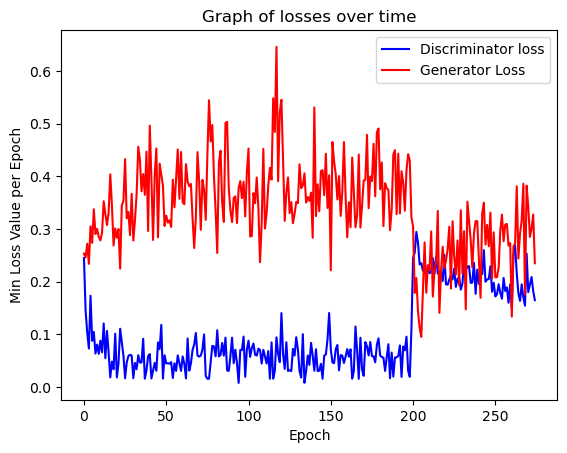

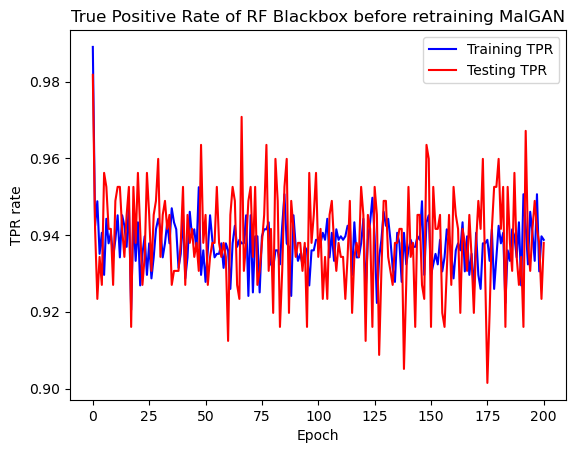

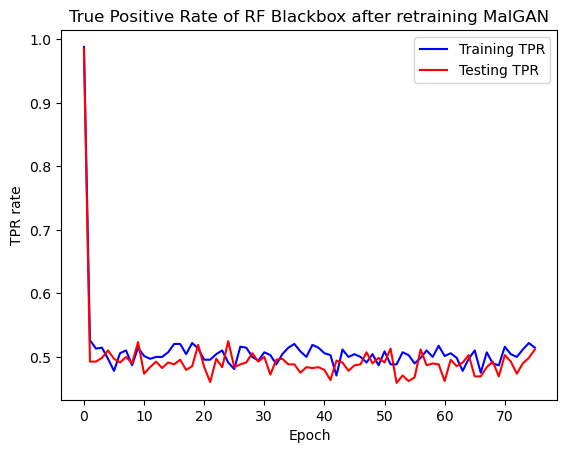

In [71]:
if __name__ == '__main__':
    main()

In [72]:
from joblib import load
# Load the model
model = load('LinearSVC.joblib')

# Print the model's parameters
print("Parameters:")
print(model.get_params())

# Check the model type and print more information accordingly
if hasattr(model, 'coef_'):
    print("\nCoefficients:")
    print(model.coef_)

if hasattr(model, 'intercept_'):
    print("\nIntercept:")
    print(model.intercept_)

if hasattr(model, 'feature_importances_'):
    print("\nFeature Importances:")
    print(model.feature_importances_)

Parameters:
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

Coefficients:
[[-6.72980276e-01 -8.81944148e-01 -1.25334548e+00  5.25013496e-01
  -7.24135138e-01  4.26630406e-01 -5.17740529e-01  7.80154763e-01
  -1.94108732e+00  6.23140996e-01  8.84320313e-01  2.93975586e-01
  -1.69071731e-01 -2.24917820e-03 -3.18959284e-01  4.26231545e-01
  -3.24514676e-01 -7.62289310e-02 -1.03474491e+00  8.54065791e-01
   8.23329322e-01 -5.48195891e-01 -2.30161600e-01 -1.89848784e-01
  -4.47380611e-01  7.63971886e-02 -7.02563393e-01  2.97948263e-01
  -4.24527524e-01 -5.37695820e-01  9.93820142e-01  5.96175536e-01
   7.37995794e-01  7.23913619e-01  2.84588313e-01 -4.64030215e-01
   7.20802991e-01 -3.26194901e-02 -3.24577590e-01  3.96956379e-01
   1.53668471e-01  4.55026988e-01  1.86157593e-01 -4.49550342e-01
  -3.65226807e-01  1